In [2]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
import random as rnd
rnd.seed()
import copy
from networkx.algorithms.community import girvan_newman


In [3]:
def drawGz(G,z):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['#d61111','#11c6d6','#d67711','#11d646','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)

    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])])
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 100
        flabel = False
        
    nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

def tabulate_wk(G,z,c):
    # This function tabulates the w_rs and kappa_r auxiliary data structures for the DC-SBM
    #
    # input  : G is simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes, into c groups
    #        : c is scalar, number of possible groups
    # output : wrs, kpr
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    wrs = np.zeros([c,c]) # count of stubs from group r to group s
    kpr = np.zeros([c,1]) # total degree of group r

    ##### do not modify above here #####
    ### YOUR CODE
    
    ##### do not modify below here #####
    
    for e in list(G.edges()):
        #etract node and its groups:
        # u, v = e 
        # r = z[u]
        # s = z[v]
        # print(e)
        r = z[int(e[0])]
        # print(r)
        s = z[int(e[1])]
        # print(s)
        #add values to structures:
        wrs[r, s] = wrs[r,s] + 1
        wrs[s, r] = wrs[s,r] + 1
        
    kpr = np.sum(wrs, axis=1) #row sum
            
    return wrs, kpr

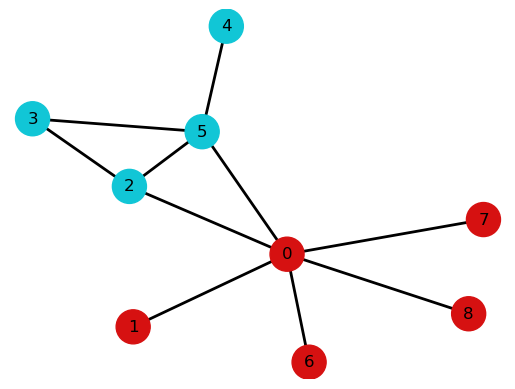

In [4]:
G = nx.Graph([(0,1),(0,2),(0,5),(0,6),(0,7),(0,8),(2,3),(2,5),(4,5),(3,5)]) # a simple graph G

# partition G into 2 groups (z as a dictionary)
z = {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0}

drawGz(G,z)

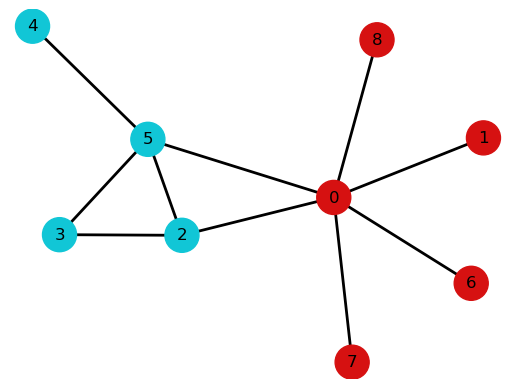

In [5]:
#clusting functions from lab 6:

def girvan_newman_clusters(G, c=None):
    communities_generator = girvan_newman(G)

    if c is None:
        # If no specific number of clusters is provided, use the first level of communities
        communities = next(communities_generator)
    else:
        # Iterate through the dendrogram until the desired number of clusters is reached
        for communities in communities_generator:
            if len(communities) >= c:
                break

    # Create a dictionary with nodes as keys and their corresponding communities as values
    z = {}
    for community_index, community in enumerate(communities):
        for node in community:
            z[node] = community_index

    return z

#not used yet
def dcsbm_LogL(wrs,kpr):
    # DO NOT MODIFY THIS FUNCTION
    # This function calculates the log-likelihood of the degree-corrected stochastic block model (DC-SBM)
    # See Eq. (9) in Lecture 6.
    #
    # input  : wrs is a c x c np.array of stub counts
    #        : kpr is a c x 1 np.array of stub counts 
    # output : the dcsbm log-likelihood
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    c = wrs.shape[1]  # number of groups
    
    logL = 0
    for r in range(c):
        for s in range(c):
            if wrs[r,s] < 1 or kpr[r] < 1 or kpr[s] < 1:
                temp = 0 # define 0^0 = 1
            else:
                temp = wrs[r,s]*np.log( wrs[r,s] / (kpr[r]*kpr[s]) )
            logL = logL + temp
    
    return logL
    # DO NOT MODIFY THIS FUNCTION

def random_z(n,c):
    # input  : number of nodes n, and number of groups c
    # output : returns a random partition in a dictionary z, where z_i = Uniform(0,c-1)

    import random as rnd
    rnd.seed()
    
    z = dict()

    ##### do not modify above here #####
    ### YOUR CODE
    
    #calc rand group # [0-c-1]for each node:
    z = {i: int(rnd.randint(0,c-1)) for i in range(n)}

    ##### do not modify below here #####

    return z

##### do not modify below here #####
##    run this code once you've written the run_OnePhase() function

# c  = 3                   # c, number of groups
# # z0 = random_z(G.nodes(), c)
# zstar  = graph_clusters(G, c)
# # drawGz(G,z0)
# drawGz(G,zstar)
c = 2
# G = nx.karate_club_graph()
z = girvan_newman_clusters(G, c)
drawGz(G,z)
##### do not modify above here #####

In [16]:
def count_cluster_neighbors(G, z, n):
    # Initialize a dictionary to store the count of neighbors in each cluster
    cluster_counts = defaultdict(int)

    # Iterate through the neighbors of the given node
    for neighbor in G.neighbors(n):
        cluster_counts[z[neighbor]] += 1

    return dict(cluster_counts)
from collections import defaultdict

def custom_formula(G, z, n):
    #using this formula to find the bridge nodes, from the graph G, most formulas/algorithms 
    #only find edges, and if a node appear in multiple edges this does not get accounted for being significant, this algorithm does.
    # it is calculated by taking the 
    # Initialize a dictionary to store the count of neighbors in each cluster
    cluster_counts = defaultdict(int)

    # Iterate through the neighbors of the given node
    for neighbor in G.neighbors(n):
        cluster_counts[z[neighbor]] += 1

    # Calculate the sum of the number of neighbors not in the node's own cluster
    own_cluster = z[n]
    sum_other_clusters = sum(count for cluster, count in cluster_counts.items() if cluster != own_cluster)

    # Calculate the total number of clusters not within the node's own cluster
    total_other_clusters = len(set(z.values()) - {own_cluster})

    # Calculate the number of neighbor nodes within the node's own cluster
    neighbors_in_own_cluster = cluster_counts[own_cluster]

    # Compute the desired formula value
    if neighbors_in_own_cluster != 0:
        result = (sum_other_clusters * total_other_clusters) / neighbors_in_own_cluster
    else:
        result = 0
        
    return result

def find_bridges(G,z,flag=1):
    #returns list of all significant bridges in G in order of most connections to other clusters
    #returns string if no bridges found
    #flag = 1, is just the list of nodes, without their score vale, flag=0, there is score value
    if not nx.has_bridges(G): return 'No Bridges Found'
    
    send = []
    for node in list(G.nodes()):
        send.append((node, custom_formula(G,z,node)))
        
    sorted_nodes = [(node, value) for node, value in sorted(send, key=lambda x: x[1]) if value != 0]
    if flag: sorted_nodes = [node for node, value in sorted(sorted_nodes, key=lambda x: x[1])]
        
    return sorted_nodes

#
def get_degree_list(G):
    # Get the degree for each node in the graph
    degree_dict = dict(G.degree())

    # Sort nodes in asceding order by their degree, can use pop() function for later use
    sorted_nodes = sorted(degree_dict.keys(), key=lambda x: degree_dict[x])

    return sorted_nodes


bridges_list = find_bridges(G,z)
degree_list = get_degree_list(G)
